In [138]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split

import seaborn as sns
sns.set_style("whitegrid")

In [3]:

class FFT:
    def __init__(self,timeSeries,fs=160):
        self.getFFT(timeSeries)

    def getFFT(self, timeSeries,fs=160):
        self.N = len(timeSeries)
        self.T = 1/fs
        self.t = np.arange(0,self.N/fs,self.T)
        f = np.fft.fftfreq(self.N,self.T)
        self.data,self.f = np.abs(np.fft.fft(timeSeries))[f>0],f[f>0]

    def plotFFT(self):
        plt.figure()
        plt.plot(self.f,(self.data)*(1/self.N))
        plt.show()
        return

    # filtragem da rede (intervalo indicado é de 0.5 até 42.0 hz)
    def bandPassFilter(self,min,max):
        self.data = self.data[(self.f>min) & (self.f<max)]
        self.f = self.f[(self.f>min) & (self.f<max)]

In [198]:

metrics = []


subjects_range = range(1, 110)
files = [3, 4, 7, 8, 11, 12]
for subject in subjects_range:
    if subject in [88, 92, 100]:
         continue
    for file in files:

        fileName = f'../downloaded_files/S{subject:03d}R{file:02d}.edf'
        
        reader = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
        annotations = reader.annotations
        codes = annotations.description
        codeArray = []     
        counter = 0
        df = pd.DataFrame(reader.get_data().T, columns=[channel.replace(".","") for channel in reader.ch_names])
        df = df[~(df == 0).all(axis=1)]
        timeArray = np.array([round(x,5) for x in np.arange(0,len(df)/160,.00625)])
        for timeVal in timeArray:
            if timeVal in annotations.onset:
                counter += 1
            codeArray.append(codes[counter-1])

        df["target"] = np.array(codeArray[:len(df)]).T
        df = [df['target']!= "T0"]




        # Create a list to store the windowed dataframes
        window_size = 160
        shift_size = 80


        # Iterate through the dataframe with the specified window and shift size
        for i in range(0, len(df) - window_size + 1, shift_size):
            
                # Extract the window of dat'a
                window_data = df[['Fp1','target']].iloc[i:i + window_size]

                fft = FFT(window_data['Fp1'])
                fft.bandPassFilter(0.5,42)
                data = {
                    'mean': [np.mean(fft.data)],
                    'max': [np.max(fft.data)],
                    'min': [np.min(fft.data)],
                    'fmax': [fft.f[np.argmax(fft.data)]],
                    'energy': [sum(fft.data*fft.data)/len(fft.data)],
                    'target': window_data['target'][i]
                }

                metrics.append(pd.DataFrame(data))
                # Append the windowed dataframe to the list
metrics = pd.concat(metrics, ignore_index=True)

In [ ]:
metricsT2 = metrics.copy()
metricsT1 = metrics[metrics['target']!= "T0"].copy()


In [ ]:
metricsT2.loc[metricsT2['target'] != 'T2', 'target'] = 0
metricsT2.loc[metricsT2['target'] == 'T2', 'target'] = 1

metricsT1.loc[metricsT1['target'] != 'T1', 'target'] = 0
metricsT1.loc[metricsT1['target'] == 'T1', 'target'] = 1


In [ ]:
calcMetric = metricsT1.copy()

In [ ]:
len(metricsT2)

156294

In [189]:
len(metricsT1)

77569

In [176]:

# Supondo que você tenha os dados X e y para treinamento

X_train_full, X_val, y_train_full, y_val = train_test_split(calcMetric[["mean"	,"max"	,"min"	,"fmax"	,"energy"]], calcMetric["target"], test_size=0.3, random_state=42)
X_train_full = X_train_full.reset_index(drop=True)
y_train_full = y_train_full.reset_index(drop=True)
y_train_full = y_train_full.astype(int)

# Definir o número de folds para a validação cruzada
n_folds = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

model = MLPClassifier(learning_rate_init= 0.3,max_iter= 500,momentum= 0.2,)

random_grid = {'hidden_layer_sizes': (5, 3),
               'activation': ['relu'],
               'solver': ['sgd'],
               
               
               }


random_search = RandomizedSearchCV(estimator= model,param_distributions=random_grid,refit='Accuracy',scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})
# Criar o modelo da rede neural
# model = Sequential()
# model.add(Dense(5, input_dim=5, activation='relu'))
# model.add(Dense(3, activation='relu'))
# model.add(Dense(2, activation='softmax'))
# optimizer = SGD(learning_rate=0.3, momentum=0.2)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Listas para armazenar os resultados de cada fold
all_accuracies = []
all_reports = []

# Iterar sobre os folds
for train_index, test_index in skf.split(X_train_full, y_train_full):
    X_train, X_test = X_train_full.loc[train_index], X_train_full.loc[test_index]
    y_train, y_test = y_train_full.loc[train_index], y_train_full.loc[test_index]


    encoder = OneHotEncoder(sparse_output=False)

    # Fit and transform the target values
    y_train = encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_test = encoder.fit_transform(y_test.values.reshape(-1, 1))
    # Treinar o modelo
    random_search.fit(X_train, y_train)

    # Avaliar o modelo no conjunto de teste
    y_pred = random_search.predict(X_test)



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_percept

In [104]:
encoder.inverse_transform(y_test)

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [105]:
report = classification_report(np.argmax(encoder.inverse_transform(y_test), axis=1), encoder.inverse_transform(y_pred))

In [107]:
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the target values
y_val = encoder.fit_transform(y_val.values.reshape(-1, 1))

In [108]:
accuracy = model.evaluate(X_val, y_val, verbose=0)

In [109]:
accuracy

[0.5635831952095032, 0.7508797645568848]

In [110]:
all_accuracies

[0.7542272210121155,
 0.7542272210121155,
 0.7542272210121155,
 0.7542272210121155,
 0.7541358470916748,
 0.7542047500610352,
 0.7542047500610352,
 0.7542047500610352,
 0.7542047500610352,
 0.7542047500610352]

In [166]:

def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

In [134]:
print(random_search.best_params_)

{'solver': 'sgd', 'hidden_layer_sizes': 5, 'activation': 'relu'}


In [135]:
print(random_search.best_score_)

0.7495612174555327


In [136]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 


In [142]:
svm_pred

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [157]:

best_scorer_index = np.nonzero(results['rank_test_Accuracy'] == 1)[0][0]
random_search.fit(X_train, y_train)
svm_pred = random_search.predict(X_val)


c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [151]:
y_val

153952    0
49657     1
134455    0
66597     0
113448    0
         ..
27568     0
115385    1
23619     1
99020     0
132275    1
Name: target, Length: 46889, dtype: object

In [152]:
y_val_ecoded = encoder.fit_transform(y_val.values.reshape(-1, 1))


In [153]:
y_val_decoded = encoder.inverse_transform(y_val_ecoded)


In [143]:
svm_pred = encoder.inverse_transform(svm_pred)


In [147]:
svm_pred.reshape(len(svm_pred),1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [164]:
len(svm_pred)

46889

In [162]:
pd.Series(y_val_ecoded.flatten())

0        1.0
1        0.0
2        0.0
3        1.0
4        1.0
        ... 
93773    1.0
93774    1.0
93775    0.0
93776    0.0
93777    1.0
Length: 93778, dtype: float64

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     11597
         1.0       0.75      1.00      0.86     35292

    accuracy                           0.75     46889
   macro avg       0.38      0.50      0.43     46889
weighted avg       0.57      0.75      0.65     46889



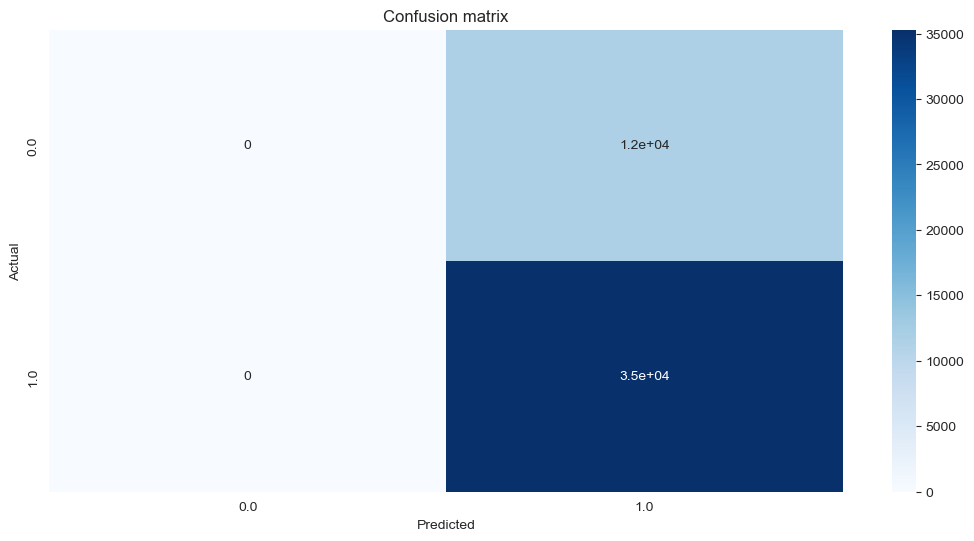

In [167]:

f1,acc = display_results(pd.Series([row[0] for row in y_val_ecoded]),pd.Series([row[0] for row in svm_pred]))

In [168]:
[row[0] for row in y_val_ecoded]

[1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0

In [169]:
[row[0] for row in svm_pred]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
